# Постепенное наращивание сети 

Попробуем сделать в tensorflow штуку посложнее. А именно, постепенно нарастить сетку, добавляя в неё новые слои и нейроны. Всё будем делать в матричном виде. Сначала подгрузим пару библиотек.

In [1]:
from IPython import display
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline

# Для визуализации обучения 
def visualize(l1,l2, h1, h2):
    plt.figure(figsize=(20,5)) 
    epo_range = range(1,len(h1)+1)
    tick_range = range(1,len(h1)+1,2)
    plt.subplot(1,2,1)
    plt.title('Learning loss')
    plt.plot(epo_range,l1, label='train set')
    plt.plot(epo_range,l2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.legend(title = 'Loss at:')
    
    plt.subplot(1,2,2)
    plt.title('Learning accuracy')
    plt.plot(epo_range,h1, label='train set')
    plt.plot(epo_range,h2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.ylim(0, 1.)
    plt.legend(title = 'Accuracy at:')
    
    display.clear_output(wait=True)
    plt.show()

In [2]:
import tensorflow as tf
import tensorflow.keras as keras  

import numpy as np
from sklearn.model_selection import train_test_split


# внутри keras уже есть набор данных, подгрузим его 
def load_dataset( ):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # нормализация матриц
    X_train = X_train.astype(np.float32) / 255.
    X_test = X_test.astype(np.float32) / 255.
    
    # вытягиваем матрицы [n,28,28] в вектрора [n,28**2]
    X_train = X_train.reshape(X_train.shape[0],28**2)
    X_test = X_test.reshape(X_test.shape[0],28**2)
    
    # сделаем OHE для таргета
    y_train = keras.utils.to_categorical(y_train).astype(np.float32)
    y_test = keras.utils.to_categorical(y_test).astype(np.float32)

    # последние 10000 примеров из трэйна оставим для валидации
    X_train, X_val, y_train, y_val =  train_test_split(X_train, y_train, test_size=0.15, stratify=y_train)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

In [3]:
X_train.shape, X_val.shape, X_test.shape

((51000, 784), (9000, 784), (10000, 784))

In [4]:
y_train.shape, y_val.shape, y_test.shape

((51000, 10), (9000, 10), (10000, 10))

Свой небольшой уютный рукописный генератор батчей для обучения. Как думаете чего в нём не хватает? 

In [5]:
def batches_generator(X, y, batch_size):
    n_batches = int(X.shape[0]/batch_size) + 1
    for batch_idx in range(n_batches):
        indices = (batch_idx*batch_size, min(X.shape[0], (batch_idx+1)*batch_size))
        yield X[indices[0]:indices[1]], y[indices[0]:indices[1]]

__Задание:__ исправьте в генераторе это небольшой недочёт. 

Собираем своего трёхслойного монстра.

In [8]:
class model_simple():
    
    def __init__(self, L1, L2, L3, learning_rate):
        self.W1 = tf.Variable(tf.random.truncated_normal([784, L1], stddev=0.1))
        self.b1 = tf.Variable(tf.zeros([L1]))

        self.W2 = tf.Variable(tf.random.truncated_normal([L1, L2], stddev=0.1))
        self.b2 = tf.Variable(tf.zeros([L2]))

        self.W3 = tf.Variable(tf.random.truncated_normal([L2, L3], stddev=0.1))
        self.b3 = tf.Variable(tf.zeros([L3]))
        self.opt = tf.optimizers.Adam(learning_rate)
        
    def generate_prediction_logits(self,X_train):
        # Определеям саму модель
        Y1 = tf.nn.relu(tf.matmul(X_train, self.W1) + self.b1)
        Y2 = tf.nn.relu(tf.matmul(Y1, self.W2) + self.b2)
        Ylogits = tf.matmul(Y2, self.W3) + self.b3
        return Ylogits
    
    def make_loss(self,X_train,y_train):
        Ylogits = self.generate_prediction_logits(X_train)
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=y_train)
        return tf.reduce_mean(cross_entropy)
    
    @tf.function
    def make_learning_step(self,X_train,y_train):
        # находим loss и пробрасываем градиент
        with tf.GradientTape() as g:
            loss = self.make_loss(X_train, y_train)
        gradients = g.gradient(loss, [self.W1,self.W2,self.W3,self.b1, self.b2,
                                     self.b3])
        self.opt.apply_gradients(zip(gradients, [self.W1,self.W2,self.W3,self.b1, self.b2,
                                     self.b3]))
        return gradients
    
    def model_acc(self,x_train,y_train):
        Ylogits = self.generate_prediction_logits(x_train)
        Y = tf.nn.softmax(Ylogits)
        correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(y_train, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return accuracy

    

Задаём модель. 

In [10]:
L1, L2, L3 = 4, 2, 10
learning_rate = 0.003

Our_Model = model_simple(L1,L2,L3,learning_rate)

Обучаем модельку. 

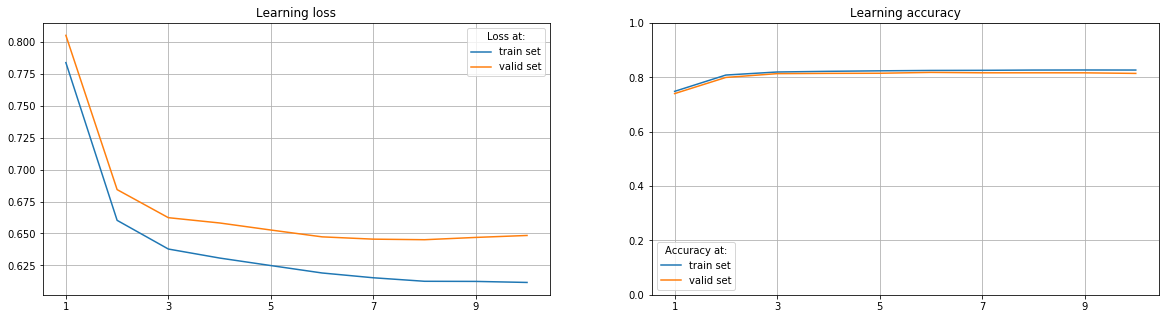

100%|██████████| 10/10 [02:17<00:00, 13.52s/it]


In [33]:
# будем писать значения метрик в вектора 
loss_test, loss_train  = [ ], [ ] 
acc_test, acc_train = [ ], [ ]
n_epochs = 10
batch_size  = 4


for i in tqdm(range(n_epochs)):

    num_batches = (X_train.shape[0] / batch_size) + 1
    
    # сгенерировали батчи 
    batch_gen = batches_generator(X_train, y_train, batch_size)
    
    # пошёл цикл по батчам 
    for X_batch, y_batch in batch_gen:
        # вся логика обучения зашита в методе
        Our_Model.make_learning_step(X_batch,y_batch)
    
    # посмотрим на качество модели на трэйне и валидации
    loss_train.append(Our_Model.make_loss(X_train,y_train))
    loss_test.append(Our_Model.make_loss(X_val,y_val))
    
    acc_train.append(Our_Model.model_acc(X_train,y_train))
    acc_test.append(Our_Model.model_acc(X_val,y_val))
    
    # визуализируем
    visualize(loss_train, loss_test, acc_train, acc_test) 

Посмотреть что за веса получилсь можно вот так: 

In [11]:
Our_Model.W1

<tf.Variable 'Variable:0' shape=(784, 4) dtype=float32, numpy=
array([[ 0.13295414,  0.09199852,  0.00931476, -0.10435009],
       [-0.00797559, -0.02248345,  0.05284264,  0.11462768],
       [-0.03190687, -0.0558244 , -0.00152228,  0.00983042],
       ...,
       [-0.04438293,  0.05361344, -0.00413755,  0.10173823],
       [-0.09422561,  0.01788586,  0.01143259,  0.043016  ],
       [ 0.0656764 ,  0.17328565,  0.06394324,  0.03400941]],
      dtype=float32)>

Давайте сохраним получившиеся веса, например в виде numpy массивов, чтобы в случае чего мы могли бы их подгрузить. Модели можно сохранять ещё и как графы вычислений. Но про это мы поговорим позже. 

In [12]:
# Веса с первого слоя 
weight_1_save = Our_Model.W1.numpy() 
bias_1_save = Our_Model.b1.numpy()

np.save('weight_1_save.npy', weight_1_save)
np.save('bias_1_save.npy', bias_1_save)

# Веса второго слоя
weight_2_save = Our_Model.W2.numpy()
bias_2_save = Our_Model.b2.numpy()

np.save('weight_2_save.npy', weight_2_save)
np.save('bias_2_save.npy', bias_2_save)

# Веса третьего слоя 
weight_3_save = Our_Model.W3.numpy()
bias_3_save = Our_Model.b3.numpy()

np.save('weight_3_save.npy', weight_3_save)
np.save('bias_3_save.npy', bias_3_save)

# загрузить веса назад можно следующим способом
bias_1_save = np.load('bias_1_save.npy')

Тепер мы хотим научиться добавлять в уже обученную сетку новые нейроны. Что такое новый нейрон, с точки зрения матриц? 

In [29]:
# Проинициализируйте новый нейрон :) 
# И дообучите сетку

# Вроде бы звучит просто...
new_col = np.random.normal(size=[4])
print(weight_1_save.shape)
print(weight_2_save.shape)
print(weight_3_save.shape)

weight_2=np.c_[weight_2_save,new_col]
bias_2 = np.append(bias_2_save, 0)
print(bias_2.shape)
print(weight_2.shape)

new_line = np.random.normal(size=[10])

weight_3 = np.vstack((weight_3_save,new_line))
print(weight_3.shape)


(784, 4)
(4, 2)
(2, 10)
(3,)
(4, 3)
(3, 10)


In [30]:
Our_Model.W2 = tf.Variable(weight_2, dtype=tf.float32)
Our_Model.W3 = tf.Variable(weight_3, dtype=tf.float32)
Our_Model.b2 = tf.Variable(bias_2, dtype=tf.float32)